<a href="https://colab.research.google.com/github/aiyingliulang/Play-with-Machine-Learning-Algorithms/blob/master/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install numpy cython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!pip install libpython m2w64-toolchain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement m2w64-toolchain (from versions: none)
ERROR: No matching distribution found for m2w64-toolchain


In [10]:
!pip install numpy cython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
!pip install matplotlib scipy pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
!pip install pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 3.8 MB/s 
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [15]:
import pandas as pd
import numpy as np
from prophet import Prophet
import sklearn

from pandas import to_datetime
from pandas import DataFrame

In [17]:
df=pd.read_excel('test.xlsx',
               usecols=['Date','oil/day'],
               )
# df['y'] = np.log(df['y'])
df=df.rename(columns={"Date": "ds", "oil/day": "y"})
df['ds']= to_datetime(df['ds'])
# model = Prophet(changepoint_prior_scale = 0.2,
#                 # growth='logistic',
#                 weekly_seasonality=False,
#                 daily_seasonality=False
#                 )  #By default, "changepoint_prior_scale" is set to 0.05. Increasing it will make the trend more flexible
# model.fit(df)
df

,ds,y
0,2013-09-01,318.03
1,2013-10-01,376.77
2,2013-11-01,337.63
3,2013-12-01,241.74
4,2014-01-01,224.87
...,...,...
93,2021-08-01,10.42
94,2021-09-01,10.63
95,2021-10-01,11.19
96,2021-11-01,10.63


In [18]:
# Hyperparameter tuning
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import itertools

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2],
    'seasonality_prior_scale': [0.001, 0.01, 0.1, 1.0]
}

cutoffs = pd.to_datetime(['2018-08-01','2019-08-01'])

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m,cutoffs=cutoffs,horizon = '365 days' ,parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpql3kc1x5/1p0dw8il.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpql3kc1x5/csfkcawv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17244', 'data', 'file=/tmp/tmpql3kc1x5/1p0dw8il.json', 'init=/tmp/tmpql3kc1x5/csfkcawv.json', 'output', 'file=/tmp/tmpql3kc1x5/prophet_modelw1uua4mv/prophet_model-20230103033631.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:36:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:36:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Applying in parallel with <

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                      0.01                    0.001  66.272282
1                      0.01                    0.010  65.137220
2                      0.01                    0.100  65.833031
3                      0.01                    1.000  65.051360
4                      0.05                    0.001  11.432122
5                      0.05                    0.010  10.772684
6                      0.05                    0.100  13.269809
7                      0.05                    1.000  11.502257
8                      0.10                    0.001   7.984938
9                      0.10                    0.010   8.661912
10                     0.10                    0.100   8.470650
11                     0.10                    1.000   7.893254
12                     0.20                    0.001   7.564905
13                     0.20                    0.010   8.647918
14                     0.20             

In [19]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 2, 'seasonality_prior_scale': 0.001}


In [21]:
df[58:]

,ds,y
58,2018-07-01,23.97
59,2018-08-01,20.31
60,2018-09-01,21.03
61,2018-10-01,19.84
62,2018-11-01,18.36
63,2018-12-01,19.19
64,2019-01-01,12.07
65,2019-02-01,17.21
66,2019-03-01,13.77
67,2019-04-01,2.00


In [22]:
model = Prophet(changepoint_prior_scale = 1,
                seasonality_prior_scale = 0.01
                )  #By default, "changepoint_prior_scale" is set to 0.05. Increasing it will make the trend more flexible
model.fit(df[:58])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpql3kc1x5/nogxo9m0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpql3kc1x5/8qvx0miy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2053', 'data', 'file=/tmp/tmpql3kc1x5/nogxo9m0.json', 'init=/tmp/tmpql3kc1x5/8qvx0miy.json', 'output', 'file=/tmp/tmpql3kc1x5/prophet_model65tdvxu3/prophet_model-20230103033937.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:39:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:39:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [23]:
future=df['ds'][58:]
future = DataFrame(future).reset_index(drop=True)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# future.head()

          ds       yhat  yhat_lower  yhat_upper
0 2018-07-01  21.194032   11.371075   30.578965
1 2018-08-01  20.074699    8.057854   30.969600
2 2018-09-01  13.706023   -2.589134   27.403837
3 2018-10-01  27.507897    4.711448   46.720011
4 2018-11-01  20.383691   -9.723644   48.628394


Text(0.5, 1.0, 'Oil Production (Training & Predicted Datasets)')

<Figure size 864x576 with 0 Axes>

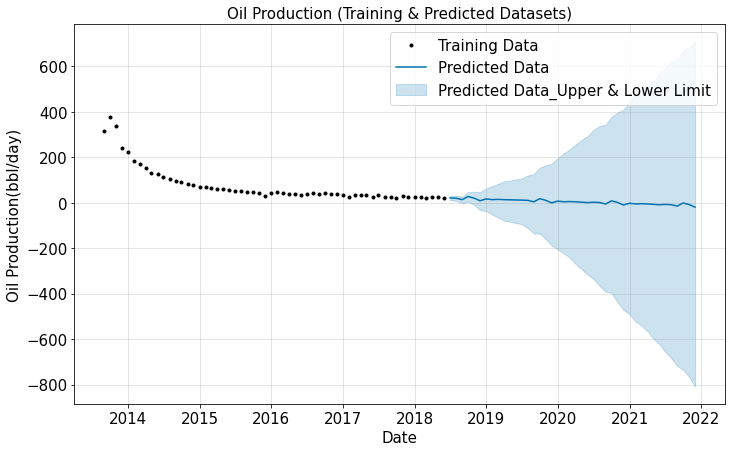

In [26]:
import matplotlib.pyplot as plt

# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
# forecast.head()
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
plt.figure(figsize=(12,8))
model.plot(forecast)
plt.ylabel('Oil Production(bbl/day)',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.legend(['Training Data', 'Predicted Data','Predicted Data_Upper & Lower Limit'],loc='upper right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Oil Production (Training & Predicted Datasets)',fontsize=15)

Text(0.5, 1.0, 'Oil Production Prediction(Prophet)')

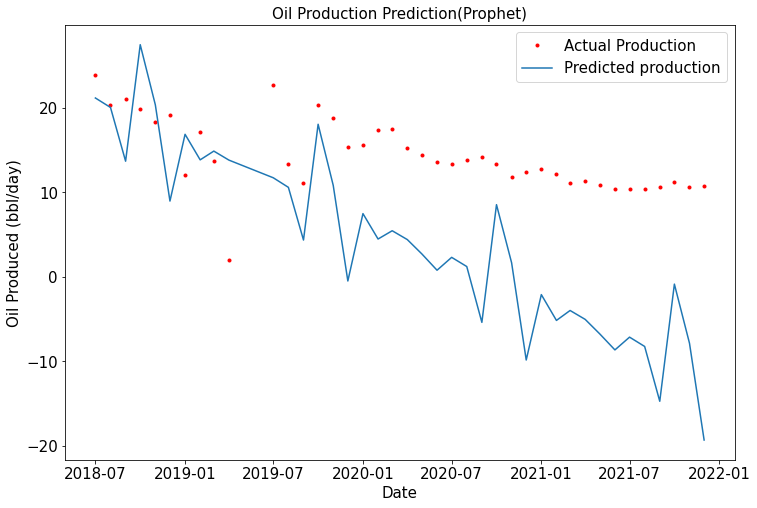

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

x1 = forecast['ds']
y1 = forecast['yhat']
# y2 = forecast['yhat_lower']
# y3 = forecast['yhat_upper']
y4 = df['y'][58:]
plt.figure(figsize=(12,8))
plt.plot(x1,y4,'.',color='red', label='Actual Production')
plt.plot(x1,y1,label='Predicted production')
# plt.plot(x1,y2)
# plt.plot(x1,y3)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Oil Produced (bbl/day)',fontsize=15)
plt.legend(loc='upper right',fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Oil Production Prediction(Prophet)',fontsize=15)
# plt.show()

# import matplotlib.ticker as ticker
# import matplotlib.dates as mdates
# ax = plt.axes()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) #'%Y-%m-%d %H:%M:%S'
# ax.xaxis.set_major_locator(ticker.MultipleLocator(182.5))
# ax.set_xlim(pd.Timestamp('2018-07'),pd.Timestamp('2020-07'))
# ax.set_ylim(0,1000)

In [29]:
# calculate MAE between expected and predicted values for december
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_error

y_true = df['y'][58:].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
r2=r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('MAE: %.2f' % mae)
print('R2 score: %.2f' % r2)
print('rmse: %.2f' % rmse)

MAE: 11.74
R2 score: -9.28
rmse: 13.58


Text(55.25, 0.5, 'Yearly Trend')

<Figure size 720x504 with 0 Axes>

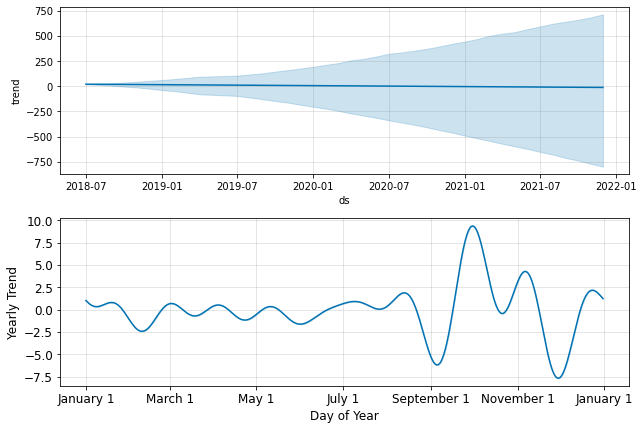

In [30]:
# fig=model.plot_components(forecast)

plt.figure(figsize=(10,7))
model.plot_components(forecast)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Day of Year',fontsize=12)
plt.ylabel('Yearly Trend',fontsize=12)


# plt.figure(figsize=(12,8))
# x1 = forecast['ds']
# y1 = forecast['yearly']
# plt.plot(x1,y1,label='Yearly Trend')

# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.title('Trend of Yearly Production',fontsize=15)